In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os

import math  
import sys  
sys.path.append('C:/Users/j/hotai/myfolder')

from my_function import miscore, siscore
# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

addp=5
startp=90
endp=120
dp=endp-startp
p_tot=addp*(dp-1)+1
file_tot=100
n=25
xstart=0
xend=25

In [2]:
def read_data(file_path,file_name,n,file_start=0,file_end=0,xstart=0,xend=0):
    x=np.zeros((121,n,n))
    y=np.zeros((121,n,n))
    vx=np.zeros((121,n,n))
    vy=np.zeros((121,n,n))
    for i in range(file_start,file_end):
        xp=[]
        yp=[]
        vxp=[]
        vyp=[]
        isvalid=[]
        xtmp=[]
        ytmp=[]
        vxtmp=[]
        vytmp=[]
        isvalidtmp=[]
        
        for root,dirs,files in os.walk(file_path):
            #print(root)
            
            for dir in dirs:
                #print(os.path.join(root,file))
                
    
                    with open(os.path.join(root,dir,file_name[i]), 'r') as f:  
                        lines = f.readlines()
                        for line in lines[3:]: 
                            num=line.split()
                            xtmp.append(float(num[0]))
                            ytmp.append(float(num[1]))
                            vxtmp.append(float(num[2]))
                            vytmp.append(float(num[3]))
                            isvalidtmp.append(float(num[4]))
        
                    xp.append(np.array(xtmp).reshape(25,25))
                    yp.append(np.array(ytmp).reshape(25,25))
                    vxp.append(np.array(vxtmp).reshape(25,25))
                    vyp.append(np.array(vytmp).reshape(25,25))
                    isvalid.append(np.array(isvalidtmp).reshape(25,25))
                    xtmp=[]
                    ytmp=[]
                    vxtmp=[]
                    vytmp=[]
                    isvalidtmp=[]
        #
        xp=np.array(xp)
        yp=np.array(yp)
        vxp=np.array(vxp)
        vyp=np.array(vyp)
        isvalid=np.array(isvalid)
        x=x+xp/file_tot
        y=y+yp/file_tot
        vx=vx+vxp/file_tot
        vy=vy+vyp/file_tot
    x=x.T
    x=x[xstart:xend,xstart:xend]
    y=y.T
    y=y[xstart:xend,xstart:xend]
    vx=vx.T
    vx=vx[xstart:xend,xstart:xend]
    vy=vy.T
    vy=vy[xstart:xend,xstart:xend]
    isvalid=isvalid.T
    isvalid=isvalid[xstart:xend,xstart:xend]
    return x,y,vx,vy

In [3]:
file_path = os.path.join('D:\\', 'hotaidata','sr_C6_01')
file_name=['B00001.dat','B00002.dat','B00003.dat','B00004.dat','B00005.dat','B00006.dat','B00007.dat','B00008.dat',
           'B00009.dat','B00010.dat','B00011.dat','B00012.dat','B00013.dat','B00014.dat','B00015.dat','B00016.dat','B00017.dat',
           'B00018.dat','B00019.dat','B00020.dat','B00021.dat','B00022.dat','B00023.dat','B00024.dat','B00025.dat','B00026.dat',
           'B00027.dat','B00028.dat','B00029.dat','B00030.dat','B00031.dat','B00032.dat','B00033.dat','B00034.dat','B00035.dat',
           'B00036.dat','B00037.dat','B00038.dat','B00039.dat','B00040.dat','B00041.dat','B00042.dat','B00043.dat','B00044.dat',
           'B00045.dat','B00046.dat','B00047.dat','B00048.dat','B00049.dat','B00050.dat','B00051.dat','B00052.dat','B00053.dat',
           'B00054.dat','B00055.dat','B00056.dat','B00057.dat','B00058.dat','B00059.dat','B00060.dat','B00061.dat','B00062.dat',
           'B00063.dat','B00064.dat','B00065.dat','B00066.dat','B00067.dat','B00068.dat','B00069.dat','B00070.dat','B00071.dat',
           'B00072.dat','B00073.dat','B00074.dat','B00075.dat','B00076.dat','B00077.dat','B00078.dat','B00079.dat','B00080.dat',
           'B00081.dat','B00082.dat','B00083.dat','B00084.dat','B00085.dat','B00086.dat','B00087.dat','B00088.dat','B00089.dat',
           'B00090.dat','B00091.dat','B00092.dat','B00093.dat','B00094.dat','B00095.dat','B00096.dat','B00097.dat','B00098.dat',
           'B00099.dat','B00100.dat']
x=np.zeros((121,n,n))
y=np.zeros((121,n,n))
vx=np.zeros((121,n,n))
vy=np.zeros((121,n,n))

x,y,vx,vy=read_data(file_path,file_name,25,0,50,xstart,xend)
#print(x[0,:,:])
t=np.linspace(0,60/800,121)
dt=t[1]-t[0]

t=t[startp:endp]
print(len(t))
t_train=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
dt_train=t_train[1]-t_train[0]
print(len(t_train.shape))

30
1


In [4]:
#u is not pre adding, v add a median
spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T

n=xend-xstart

t_in=np.zeros((n,n,dp))
for i in range (dp):
    t_in[:,:,i]=t[i]

print(t_in[0,0])

u=np.zeros((n,n,121, 3))

u[:, :, :, 0] = vx
u[:, :, :, 1] = vy
u[:, :, startp:endp, 2] = t_in
u_train=np.zeros((n,n,len(t), 3))
u_train=u[:,:,startp:endp,:]

v_train=np.zeros((n,n,len(t_train),3))

for i in range(len(t)-1):
    for j in range(addp):
        v_train[:,:,addp*i+j]=(u_train[:,:,i]*(addp-j)+u_train[:,:,i+1]*j)/addp
v_train[:,:,-1]=u_train[:,:,-1]


[0.05625  0.056875 0.0575   0.058125 0.05875  0.059375 0.06     0.060625
 0.06125  0.061875 0.0625   0.063125 0.06375  0.064375 0.065    0.065625
 0.06625  0.066875 0.0675   0.068125 0.06875  0.069375 0.07     0.070625
 0.07125  0.071875 0.0725   0.073125 0.07375  0.074375]


<function matplotlib.pyplot.show(close=None, block=None)>

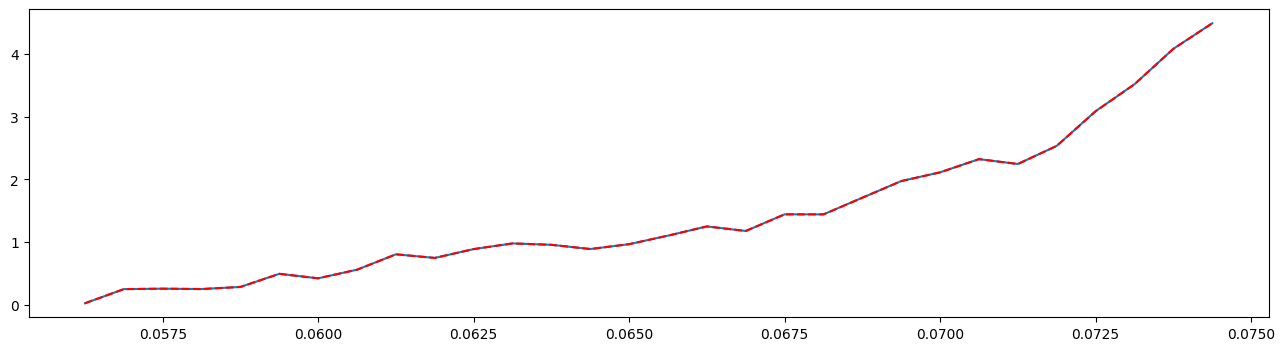

In [5]:
op=np.zeros(len(t))
op=u_train[10,10,:,0]
op_train=np.zeros(len(t_train))
for i in range(len(t)-1):
    for j in range(addp):
        op_train[i*addp+j]=(op[i]*(addp-j)+op[i+1]*j)/addp
op_train[-1]=op[-1]
plt.figure(figsize=(16, 4))
plt.plot(t,op)
plt.plot(t_train,op_train,'r--')
plt.show

In [6]:
v_train_dot = ps.FiniteDifference(axis=2)._differentiate(v_train, dt_train)

vtmp=np.zeros(v_train_dot.shape)
vtmp[:,:,0]=v_train[:,:,0]
for i in range(len(t_train)-1):
    vtmp[:,:,i+1]=vtmp[:,:,i]+v_train_dot[:,:,i]*dt_train
miscore(vtmp,v_train)
siscore(vtmp,v_train)
vtmp=v_train+v_train_dot*dt_train

vtmp[:,:,1:]=vtmp[:,:,:len(t_train)-1]
miscore(vtmp,v_train)
siscore(vtmp,v_train)


MI(average/percent):
0.9957774001416696 0.9997569597878921
SI(average/percent):
0.9999999999999895 1.0
MI(average/percent):
0.9991837746583707 0.9999779054352629
SI(average/percent):
0.9999497164065217 1.0


(0.9999497164065217, 1.0)

In [7]:
# Define PDE library that is quadratic in u, and
# fourth-order in spatial derivatives of u.    periodic=True

library_functions = [
    lambda y: y,
    lambda x: x*x,
    
    lambda x, y: x * y,
    lambda x, y: x * x * y,
    lambda x , y , z: x * y * z
]
library_function_names = [
    lambda y: y,
    lambda x: x+x,
    
    lambda x, y: x + y,
    lambda x, y: x + x + y,
    lambda x , y , z: x + y + z
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=1,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True
    
)




print('SINDy')
model = ps.SINDy(feature_library=pde_lib, feature_names=['Vx','Vy','t'])

model.fit(v_train, x_dot=v_train_dot)
model.print()
#u_dot_stlsq = model.predict(v_train)x_dot=v_train_dot
'''
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5, 
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy','t'])
model.fit(v_train, dt_train)
model.print()'''

SINDy
(Vx)' = 4662.203 1 + 46.266 Vx + 85.934 Vy + -149241.492 t + -84.658 VxVx + -62.902 VyVy + 1194413.705 tt + 7.005 VxVy + -639.295 Vxt + -1029.204 Vyt + -0.111 VxVxVy + 1313.270 VxVxt + 1077.364 VyVyt + -201.285 VxVyt + 6815.586 Vx_2 + -7919.835 Vy_2 + 588.178 Vx_1 + -3322.704 Vy_1 + -392.117 VxVx_2 + 812.069 VxVy_2 + -217146.445 Vxt_2 + -16.971 VyVx_2 + -85.560 VyVy_2 + 1733606.180 Vyt_2 + 61.362 tVx_2 + 5579.844 tVy_2 + -13728.618 tt_2 + 1.807 VxVxVx_2 + 109.076 VxVxVy_2 + 1228.644 VxVxt_2 + -815.592 VyVyVx_2 + -1042.437 VyVyVy_2 + -239.139 VyVyt_2 + 254670.779 ttVx_2 + 106.399 ttVy_2 + 17.227 ttt_2 + -2032929.553 VxVyVx_2 + 125.704 VxVyVy_2 + 17020.075 VxVyt_2 + 3688.346 VxtVx_2 + -1.078 VxtVy_2 + -1691.928 Vxtt_2 + -250.965 VytVx_2 + -1718.690 VytVy_2 + -243.745 VxVx_1 + -357.531 VxVy_1 + -11594.217 Vxt_1 + 62.962 VyVx_1 + 115.032 VyVy_1 + 37725.039 Vyt_1 + 115.303 tVx_1 + 3531.730 tVy_1 + 4211.971 tt_1 + 1.824 VxVxVx_1 + -1011.814 VxVxVy_1 + -1467.776 VxVxt_1 + -1438.768 VyVy

"\nprint('STLSQ model: ')\noptimizer = ps.STLSQ(threshold=50, alpha=1e-5, \n                     normalize_columns=True, max_iter=200)\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy','t'])\nmodel.fit(v_train, dt_train)\nmodel.print()"

In [8]:
print("Model score: %f" % model.score(u_train, t=t))
print("Model score: %f" % model.score(u_train, t=dt))
print("Model score: %f" % model.score(v_train, t=t_train))
print("Model score: %f" % model.score(v_train, t=dt_train))

Model score: -7.056792
Model score: -22.409265
Model score: 0.374103
Model score: 0.423263


In [9]:
x_test,y_test,vx_test,vy_test=read_data(file_path,file_name,25,50,100,xstart,xend)


t_test=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
dt_test=t_test[1]-t_test[0]

si_t=np.zeros(p_tot)
mi_t=np.zeros(p_tot)
si_t_per=np.zeros(p_tot)
mi_t_per=np.zeros(p_tot)

In [10]:
#u is not pre adding, v add a median


n=xend-xstart


u[:, :, :, 0] = vx_test
u[:, :, :, 1] = vy_test

u_test=np.zeros((n,n,len(t), 3))
u_test=u[:,:,startp:endp,:]

v_test=np.zeros((n,n,len(t_test),3))
for i in range(len(t)-1):
    for j in range(addp):
        v_test[:,:,addp*i+j]=(u_test[:,:,i]*(addp-j)+u_test[:,:,i+1]*j)/addp
v_test[:,:,-1]=u_test[:,:,-1]


In [11]:
x_dot_test_predicted = model.predict(v_test)
x_dot_test_predicted=x_dot_test_predicted.reshape(n,n,p_tot,3)
tlen=len(t_train)
dot_tmp=np.array(x_dot_test_predicted)
pltpredict=np.zeros((n,n,tlen,2))
#print(dot_tmp[10,10])

In [12]:
print('add 7 point, from 80 to 120, with library x^3, derivative order 2, MI:0.6748241001379309, SI:0.8570345301079201')
print('add 7 point, from 80 to 120, with library x^3, derivative order 1, MI:0.6732771082529756, SI:0.8589308511150588')
print('add 7 point, from 80 to 120, with library x^2, derivative order 2, MI:0.6707939885275049, SI:0.8459658232811543')
print('add 7 point, from 80 to 120, with library x^2, derivative order 1, MI:0.6693806511354194, SI:0.8426666431380524')
print('add 7 point, from 90 to 120, with library x^2, derivative order 1, MI:0.6709005447980256, SI:0.8424080789942714')

pltpredict[:,:,0]=v_train[:,:,0,:2]
for i in range(tlen-1):
    pltpredict[:,:,i+1]=pltpredict[:,:,i]+dot_tmp[:,:,i,:2]*dt_train
miscore(pltpredict,v_test)
siscore(pltpredict,v_test)
#print(pltpredict[10,10])
#print(v_train[10,10])

add 7 point, from 80 to 120, with library x^3, derivative order 2, MI:0.6748241001379309, SI:0.8570345301079201
add 7 point, from 80 to 120, with library x^3, derivative order 1, MI:0.6732771082529756, SI:0.8589308511150588
add 7 point, from 80 to 120, with library x^2, derivative order 2, MI:0.6707939885275049, SI:0.8459658232811543
add 7 point, from 80 to 120, with library x^2, derivative order 1, MI:0.6693806511354194, SI:0.8426666431380524
add 7 point, from 90 to 120, with library x^2, derivative order 1, MI:0.6709005447980256, SI:0.8424080789942714
MI(average/percent):
0.8891741266145933 0.8539328325231993
SI(average/percent):
0.9955268276748094 1.0


(0.9955268276748094, 1.0)

0
MI(average/percent):
0.9576396857385286 0.9838709677419355
SI(average/percent):
0.9952581640986122 1.0


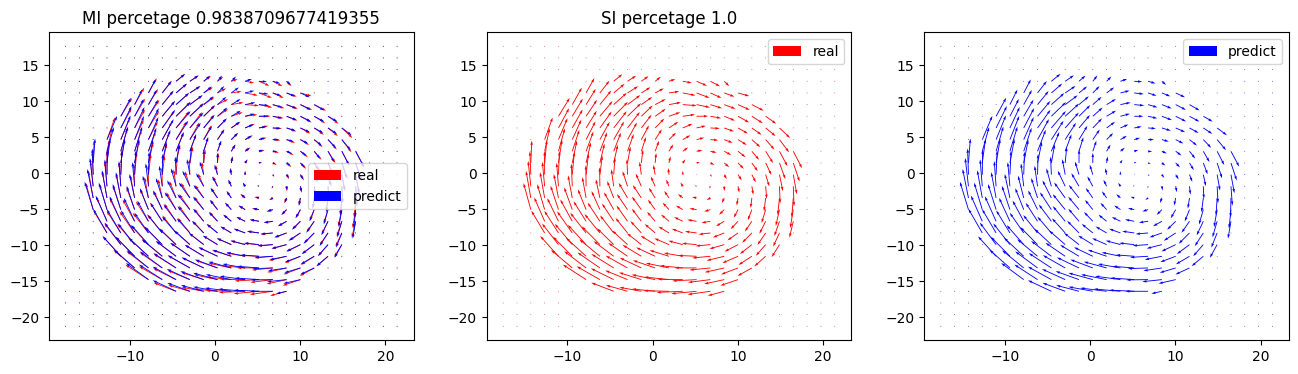

1
MI(average/percent):
0.9597912001343182 0.9903225806451613
SI(average/percent):
0.9957954912510079 1.0
2
MI(average/percent):
0.9609713061353508 0.9935483870967742
SI(average/percent):
0.9961318526540306 1.0
3
MI(average/percent):
0.961722687626376 0.9967741935483871
SI(average/percent):
0.996282171907002 1.0
4
MI(average/percent):
0.9619757441082244 0.9967741935483871
SI(average/percent):
0.9962550684516793 1.0
5
MI(average/percent):
0.961768509408011 1.0
SI(average/percent):
0.9960547048669569 1.0


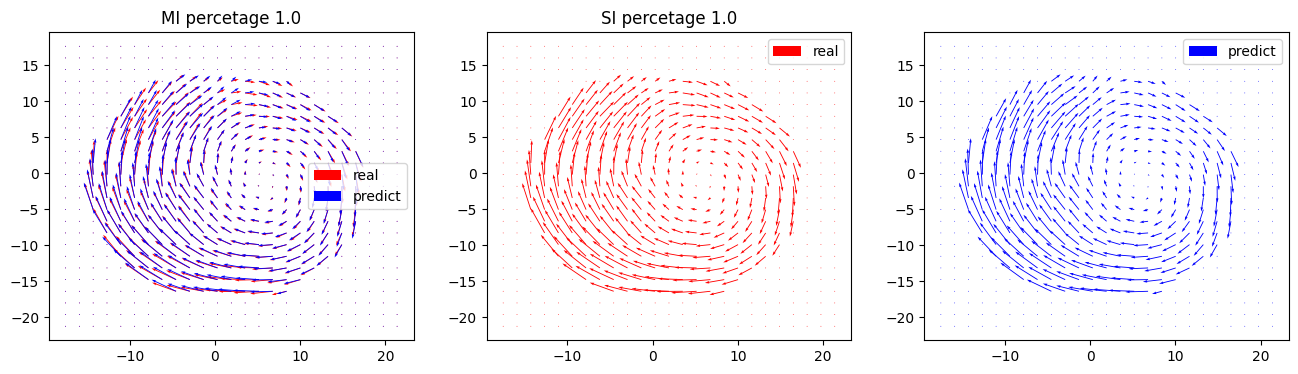

6
MI(average/percent):
0.9623877608668738 0.9935483870967742
SI(average/percent):
0.9961094508724159 1.0
7
MI(average/percent):
0.9612388119260082 0.9935483870967742
SI(average/percent):
0.9957488214907034 1.0
8
MI(average/percent):
0.959117758947183 0.9935483870967742
SI(average/percent):
0.9949109661557423 1.0
9
MI(average/percent):
0.9562033353121481 0.9838709677419355
SI(average/percent):
0.9935164327266428 0.9967741935483871
10
MI(average/percent):
0.9526591878609929 0.9774193548387097
SI(average/percent):
0.9914406507623796 0.9935483870967742


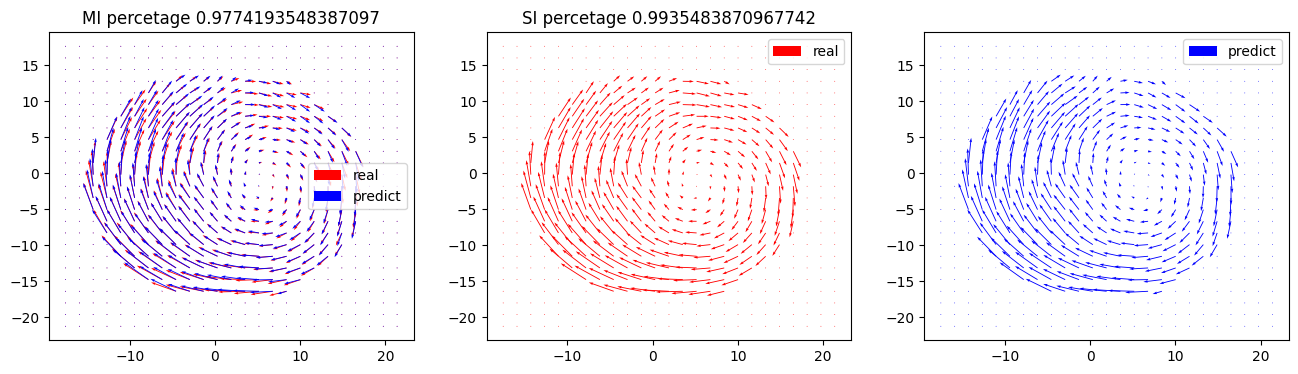

11
MI(average/percent):
0.9542265216832967 0.9774193548387097
SI(average/percent):
0.9906278113031473 0.9935483870967742
12
MI(average/percent):
0.9552761558485318 0.9838709677419355
SI(average/percent):
0.9895508290570548 0.9903225806451613
13
MI(average/percent):
0.9560355967564614 0.9806451612903225
SI(average/percent):
0.9886385224716896 0.9903225806451613
14
MI(average/percent):
0.9559708373424634 0.9838709677419355
SI(average/percent):
0.9886277543055275 0.9903225806451613
15
MI(average/percent):
0.9554273688585277 0.9806451612903225
SI(average/percent):
0.9883396359375487 0.9903225806451613


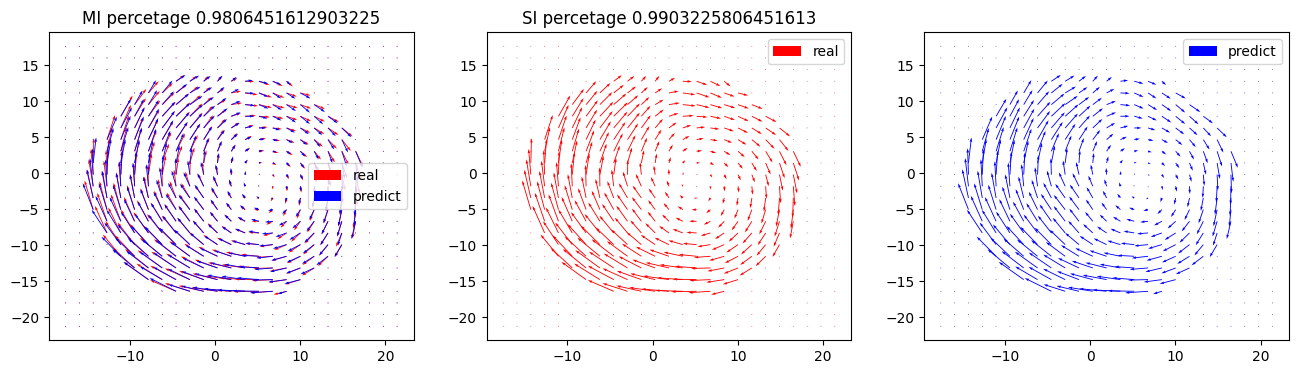

16
MI(average/percent):
0.957316809231793 0.9838709677419355
SI(average/percent):
0.9879238981297818 0.9903225806451613
17
MI(average/percent):
0.9583886380932503 0.9870967741935484
SI(average/percent):
0.9871788118525687 0.9903225806451613
18
MI(average/percent):
0.9585342050762335 0.9838709677419355
SI(average/percent):
0.9860859478584602 0.9903225806451613
19
MI(average/percent):
0.9579156579411565 0.9838709677419355
SI(average/percent):
0.9846238882077774 0.9935483870967742
20
MI(average/percent):
0.9563981307144372 0.9838709677419355
SI(average/percent):
0.9832383404759354 0.9935483870967742


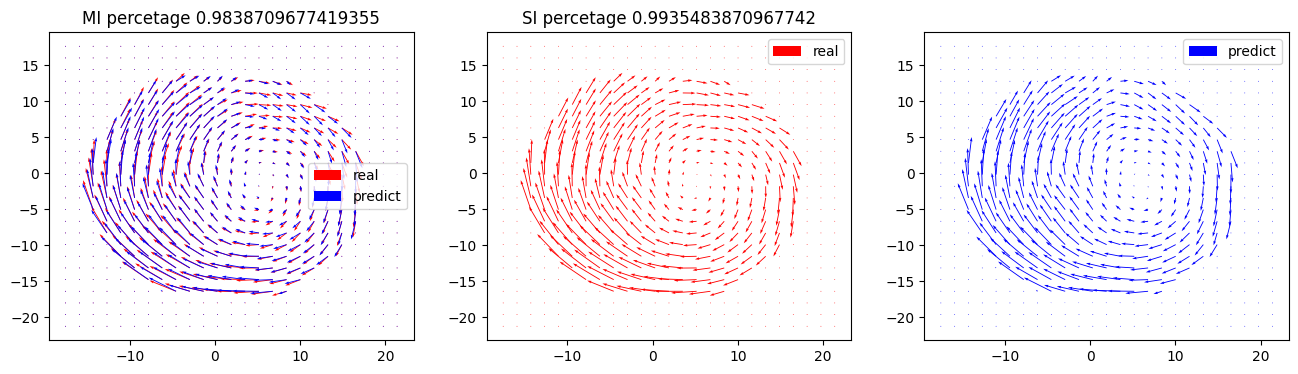

21
MI(average/percent):
0.9564603395140384 0.9838709677419355
SI(average/percent):
0.9829847378229191 0.9935483870967742
22
MI(average/percent):
0.9562083666820248 0.9838709677419355
SI(average/percent):
0.9826472114170464 0.9935483870967742
23
MI(average/percent):
0.9555226193100644 0.9838709677419355
SI(average/percent):
0.9822355049615514 0.9903225806451613
24
MI(average/percent):
0.954219165379779 0.9806451612903225
SI(average/percent):
0.9817556340907593 0.9903225806451613
25
MI(average/percent):
0.9521631753569567 0.9806451612903225
SI(average/percent):
0.9812099911030162 0.9903225806451613


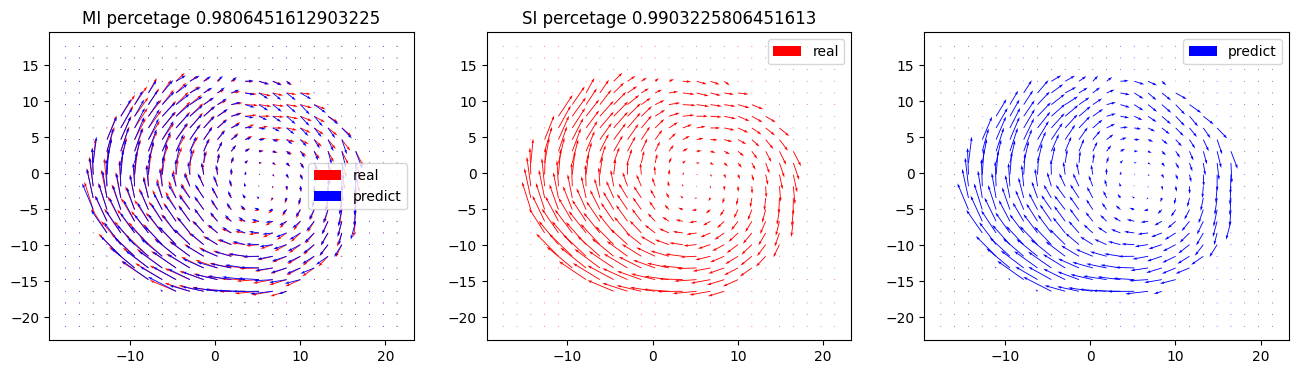

26
MI(average/percent):
0.9529440140350617 0.9806451612903225
SI(average/percent):
0.9817984538775508 0.9903225806451613
27
MI(average/percent):
0.9527017828703187 0.9838709677419355
SI(average/percent):
0.9825941987468031 0.9903225806451613
28
MI(average/percent):
0.9520866307313347 0.9838709677419355
SI(average/percent):
0.9831361326971921 0.9903225806451613
29
MI(average/percent):
0.9507778181663569 0.9838709677419355
SI(average/percent):
0.9834471656113062 0.9903225806451613
30
MI(average/percent):
0.9486496702332736 0.9741935483870968
SI(average/percent):
0.983548841717558 0.9903225806451613


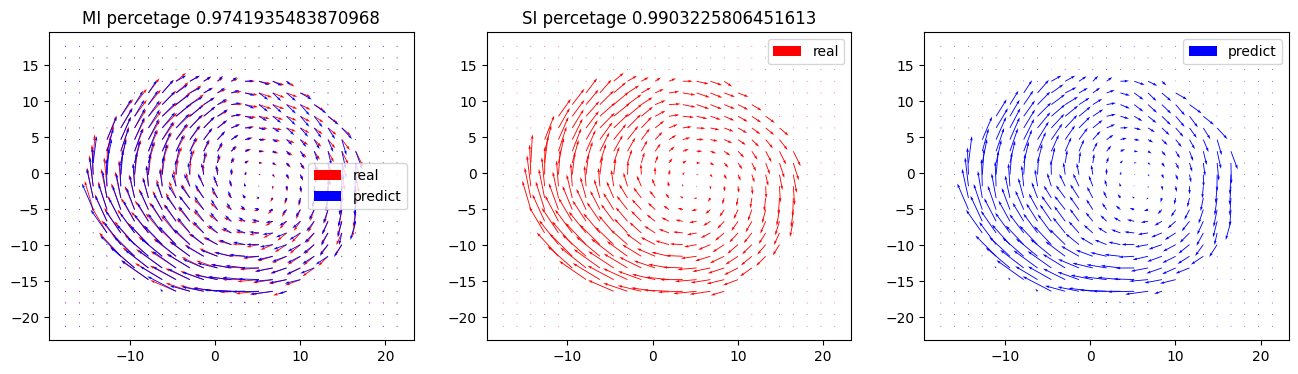

31
MI(average/percent):
0.94861828213195 0.9774193548387097
SI(average/percent):
0.9829804733095395 0.9903225806451613
32
MI(average/percent):
0.947829293411559 0.9806451612903225
SI(average/percent):
0.9821345399673885 0.9903225806451613
33
MI(average/percent):
0.9461140585649609 0.9806451612903225
SI(average/percent):
0.9810444018307072 0.9903225806451613
34
MI(average/percent):
0.9435229101496657 0.9741935483870968
SI(average/percent):
0.9797227595268269 0.9870967741935484
35
MI(average/percent):
0.9404748374580933 0.964516129032258
SI(average/percent):
0.9781715180472853 0.9870967741935484


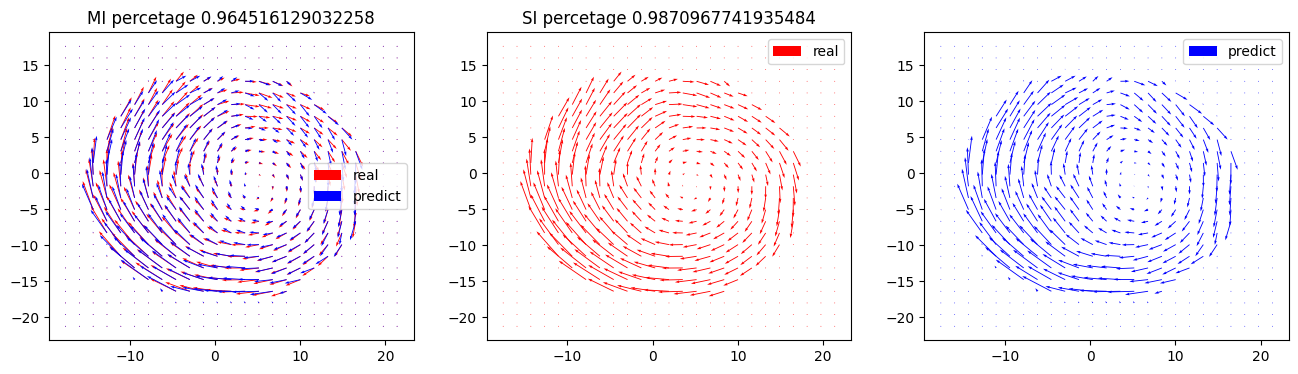

36
MI(average/percent):
0.9380371272548609 0.9580645161290322
SI(average/percent):
0.9779110965248146 0.9870967741935484
37
MI(average/percent):
0.9354409489864207 0.9548387096774194
SI(average/percent):
0.9773280443042465 0.9870967741935484
38
MI(average/percent):
0.9326150797268391 0.9580645161290322
SI(average/percent):
0.9764534598910011 0.9838709677419355
39
MI(average/percent):
0.9292339906374759 0.9419354838709677
SI(average/percent):
0.9722001877004809 0.9806451612903225
40
MI(average/percent):
0.9269118398721514 0.9419354838709677
SI(average/percent):
0.9740481355811702 0.9774193548387097


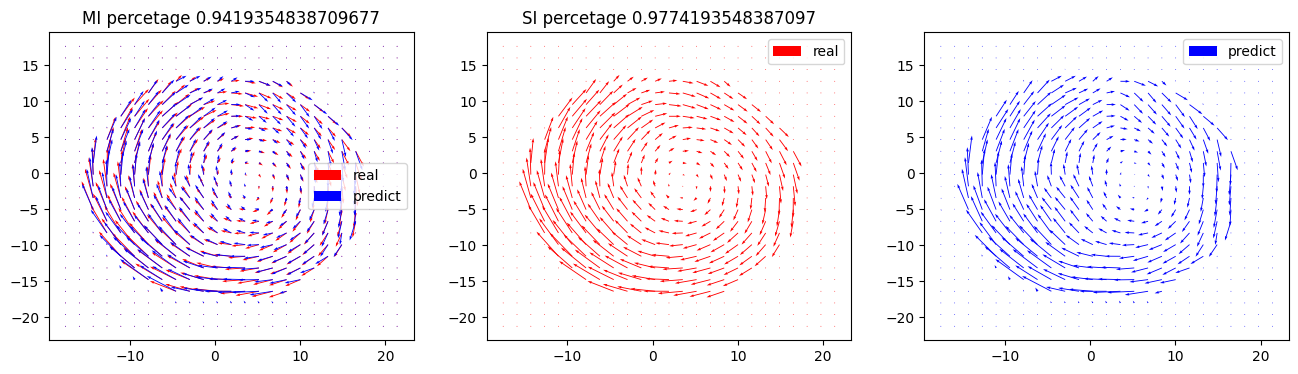

41
MI(average/percent):
0.9255197236206338 0.9387096774193548
SI(average/percent):
0.9729042579236221 0.9741935483870968
42
MI(average/percent):
0.9235696503389003 0.932258064516129
SI(average/percent):
0.97138265056752 0.967741935483871
43
MI(average/percent):
0.9209710368056718 0.9225806451612903
SI(average/percent):
0.9694258160054685 0.967741935483871
44
MI(average/percent):
0.9178723563922165 0.9161290322580645
SI(average/percent):
0.966958178783469 0.964516129032258
45
MI(average/percent):
0.9142535746615297 0.9193548387096774
SI(average/percent):
0.9640982497722502 0.9612903225806452


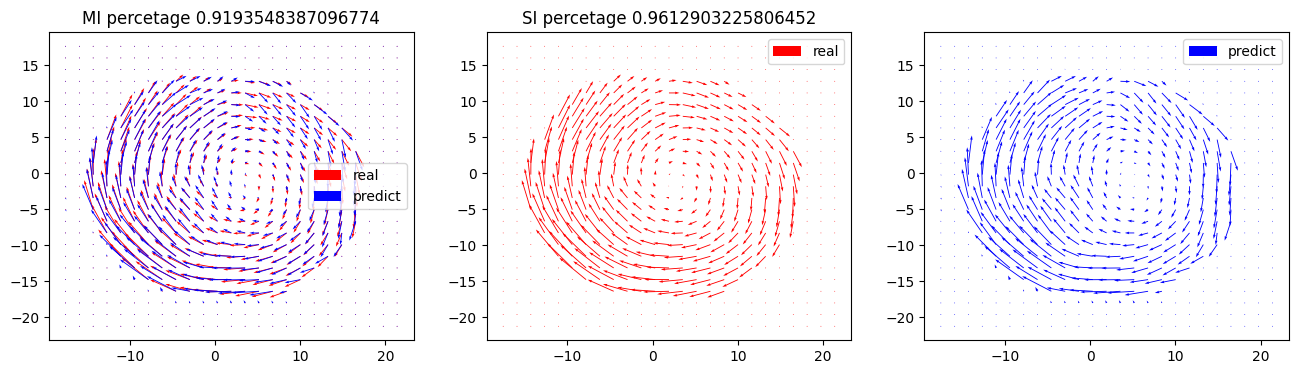

46
MI(average/percent):
0.9144873849747983 0.9129032258064517
SI(average/percent):
0.9626134720249674 0.9612903225806452
47
MI(average/percent):
0.9143023996301283 0.9064516129032258
SI(average/percent):
0.9607422608127231 0.9612903225806452
48
MI(average/percent):
0.9137938387314601 0.9064516129032258
SI(average/percent):
0.9586135838774076 0.9612903225806452
49
MI(average/percent):
0.912849490749163 0.9032258064516129
SI(average/percent):
0.9560929063596618 0.9612903225806452
50
MI(average/percent):
0.9114815196810193 0.9064516129032258
SI(average/percent):
0.9534942365670426 0.9580645161290322


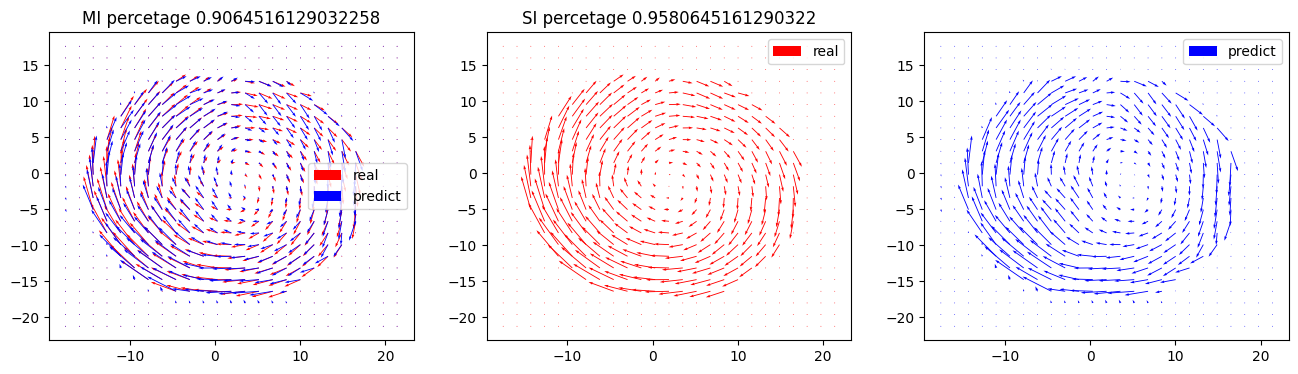

51
MI(average/percent):
0.9107455730261619 0.9064516129032258
SI(average/percent):
0.9548620746534969 0.9580645161290322
52
MI(average/percent):
0.9099725859984276 0.9032258064516129
SI(average/percent):
0.9552020664380042 0.9516129032258065
53
MI(average/percent):
0.908998651125432 0.9032258064516129
SI(average/percent):
0.9547001865648904 0.9483870967741935
54
MI(average/percent):
0.907936009644177 0.896774193548387
SI(average/percent):
0.9538368488365425 0.9483870967741935
55
MI(average/percent):
0.9067318586422942 0.896774193548387
SI(average/percent):
0.9530369240312396 0.9483870967741935


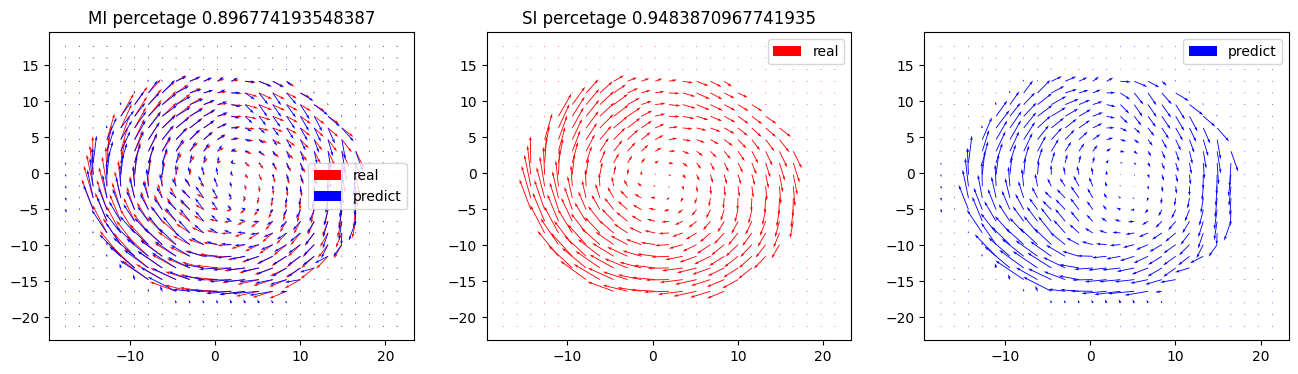

56
MI(average/percent):
0.9052549056965156 0.8903225806451613
SI(average/percent):
0.951993050189556 0.9451612903225807
57
MI(average/percent):
0.9037118789763718 0.8903225806451613
SI(average/percent):
0.9505097661495131 0.9483870967741935
58
MI(average/percent):
0.9021001817985042 0.8870967741935484
SI(average/percent):
0.9485255700207932 0.9483870967741935
59
MI(average/percent):
0.9003723430213073 0.8774193548387097
SI(average/percent):
0.9460311616306867 0.9451612903225807
60
MI(average/percent):
0.8984823382656504 0.8741935483870967
SI(average/percent):
0.9438392703789985 0.9451612903225807


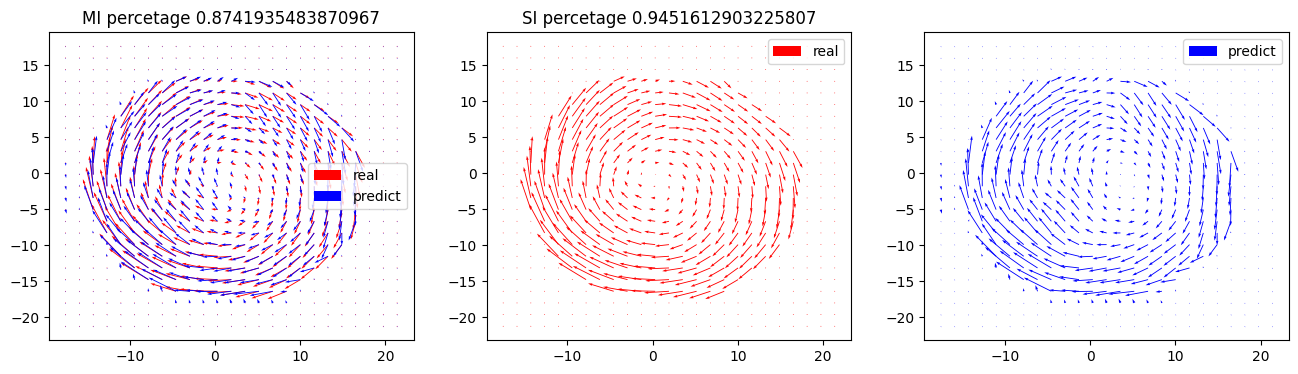

61
MI(average/percent):
0.8984584801664862 0.8709677419354839
SI(average/percent):
0.942482298852908 0.9419354838709677
62
MI(average/percent):
0.898070656266183 0.8806451612903226
SI(average/percent):
0.9407287538859429 0.9354838709677419
63
MI(average/percent):
0.8976931837729474 0.8838709677419355
SI(average/percent):
0.9397571111556244 0.932258064516129
64
MI(average/percent):
0.8971253111840632 0.8806451612903226
SI(average/percent):
0.9382499329036049 0.9290322580645162
65
MI(average/percent):
0.8961320047986061 0.8774193548387097
SI(average/percent):
0.9361328403511395 0.9225806451612903


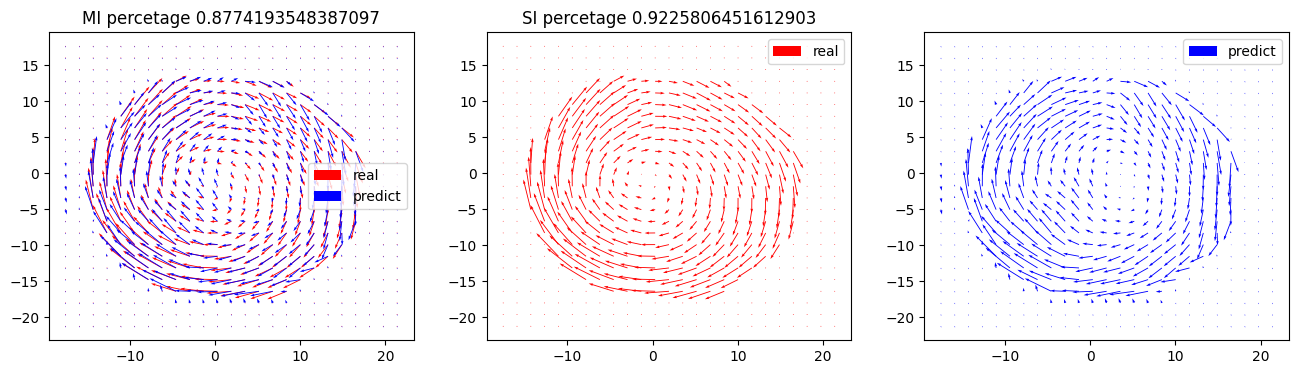

66
MI(average/percent):
0.8947507756681038 0.8806451612903226
SI(average/percent):
0.9322513396365493 0.9129032258064517
67
MI(average/percent):
0.8932506288986294 0.8774193548387097
SI(average/percent):
0.9310390130691676 0.9129032258064517
68
MI(average/percent):
0.8916970188754487 0.8741935483870967
SI(average/percent):
0.9288354571248809 0.9129032258064517
69
MI(average/percent):
0.8899180217742065 0.867741935483871
SI(average/percent):
0.9251385422452831 0.9064516129032258
70
MI(average/percent):
0.8878798357779372 0.8580645161290322
SI(average/percent):
0.9214404000018577 0.9064516129032258


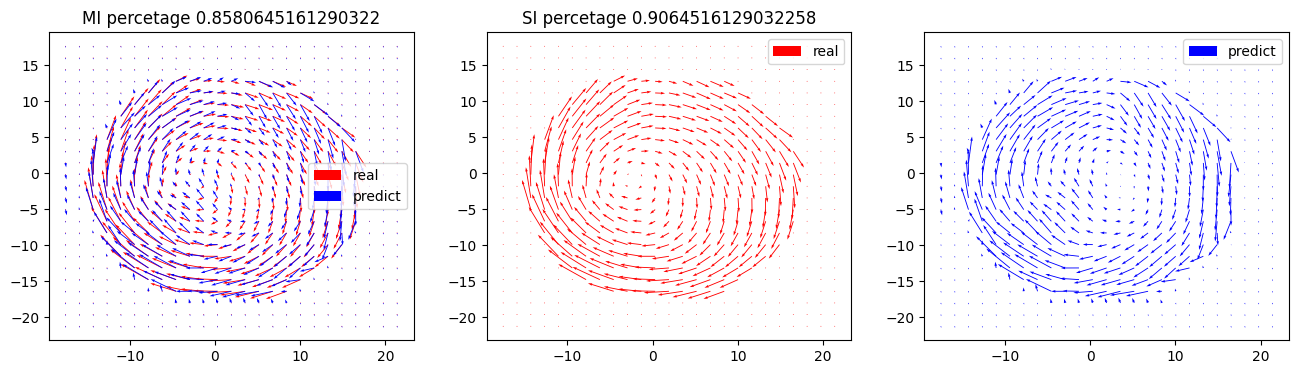

71
MI(average/percent):
0.8866228378526776 0.8612903225806452
SI(average/percent):
0.9208475925857157 0.9096774193548387
72
MI(average/percent):
0.8854515024266628 0.8580645161290322
SI(average/percent):
0.9209173688758259 0.9064516129032258
73
MI(average/percent):
0.8841905632286131 0.8580645161290322
SI(average/percent):
0.9214648362274946 0.9032258064516129
74
MI(average/percent):
0.8828284849288698 0.8580645161290322
SI(average/percent):
0.9215695831483944 0.9032258064516129
75
MI(average/percent):
0.8811582629623818 0.8483870967741935
SI(average/percent):
0.9210468916175243 0.9032258064516129


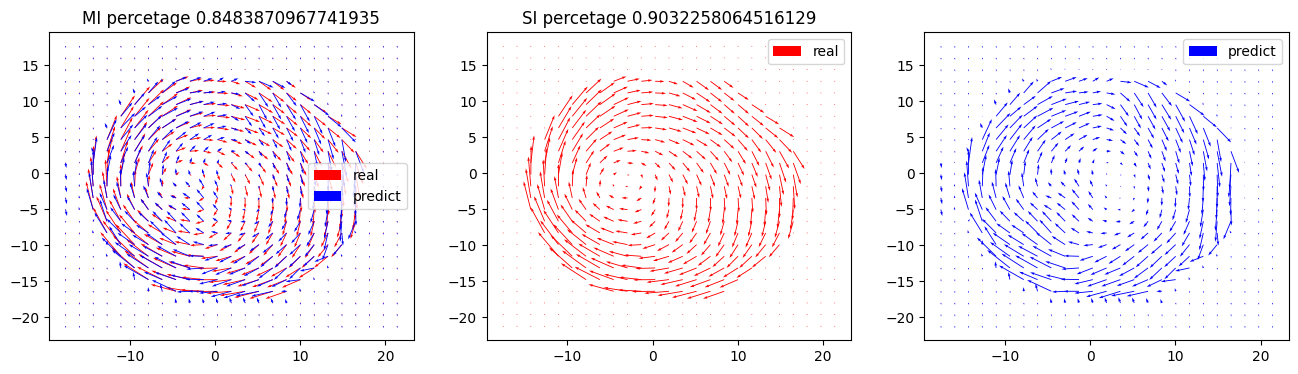

76
MI(average/percent):
0.88090038082221 0.8483870967741935
SI(average/percent):
0.9207492684813114 0.9064516129032258
77
MI(average/percent):
0.8804888428926347 0.8483870967741935
SI(average/percent):
0.9202960008910771 0.9
78
MI(average/percent):
0.8799856787399104 0.8451612903225807
SI(average/percent):
0.9203449438527305 0.896774193548387
79
MI(average/percent):
0.8790612260013873 0.8387096774193549
SI(average/percent):
0.9200422425774449 0.8935483870967742
80
MI(average/percent):
0.8779874343557932 0.8419354838709677
SI(average/percent):
0.9173062524199065 0.8903225806451613


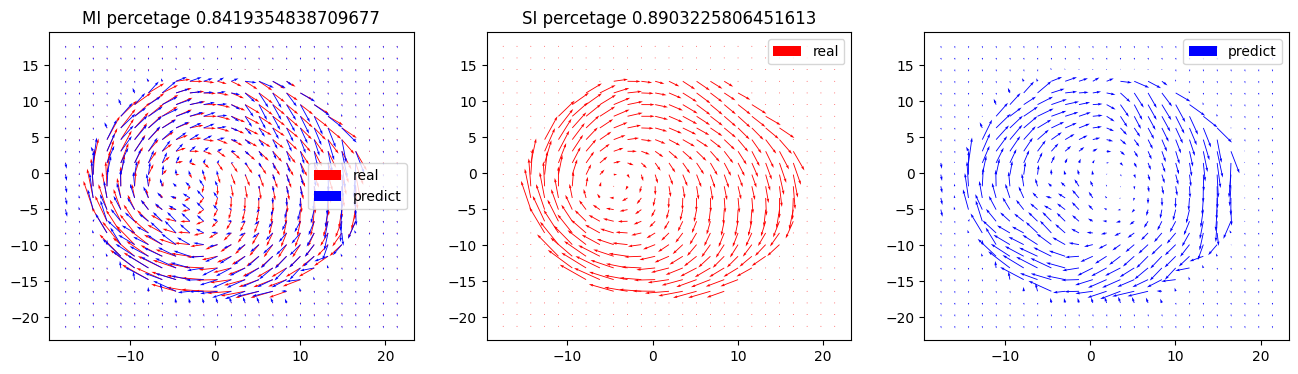

81
MI(average/percent):
0.8758808026359252 0.8483870967741935
SI(average/percent):
0.9155307500286353 0.8838709677419355
82
MI(average/percent):
0.8737229471077306 0.8419354838709677
SI(average/percent):
0.9145012546737928 0.8774193548387097
83
MI(average/percent):
0.8712651936752063 0.8451612903225807
SI(average/percent):
0.9128633362580824 0.8774193548387097
84
MI(average/percent):
0.8687528761184946 0.8354838709677419
SI(average/percent):
0.910798100372565 0.8741935483870967
85
MI(average/percent):
0.8661496114020442 0.832258064516129
SI(average/percent):
0.9082548879120173 0.867741935483871


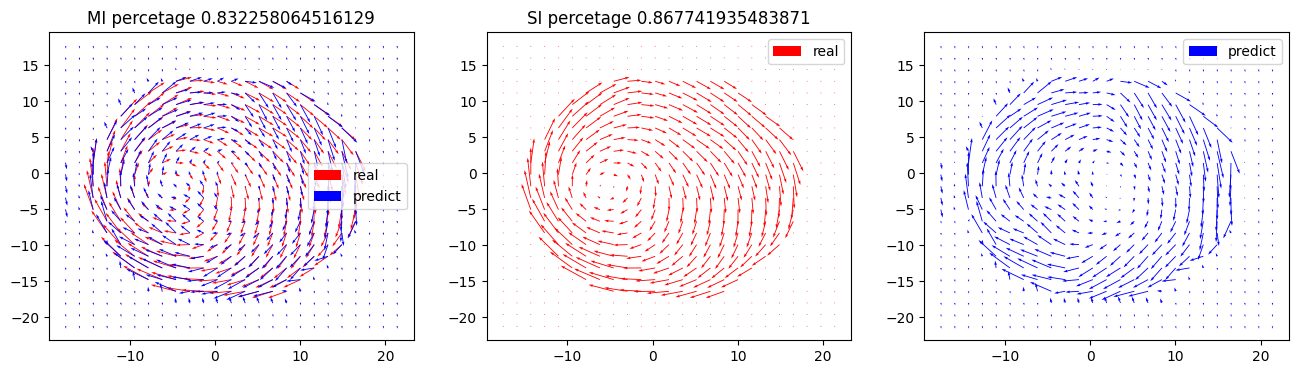

86
MI(average/percent):
0.8653969621563312 0.8258064516129032
SI(average/percent):
0.9064785749252533 0.864516129032258
87
MI(average/percent):
0.8645466879994261 0.8290322580645161
SI(average/percent):
0.9046995475120481 0.864516129032258
88
MI(average/percent):
0.8631041141720545 0.8193548387096774
SI(average/percent):
0.9035475928916584 0.864516129032258
89
MI(average/percent):
0.8614548772983504 0.8193548387096774
SI(average/percent):
0.9017860558973292 0.8548387096774194
90
MI(average/percent):
0.8596825821906402 0.8225806451612904
SI(average/percent):
0.8981015452761872 0.8516129032258064


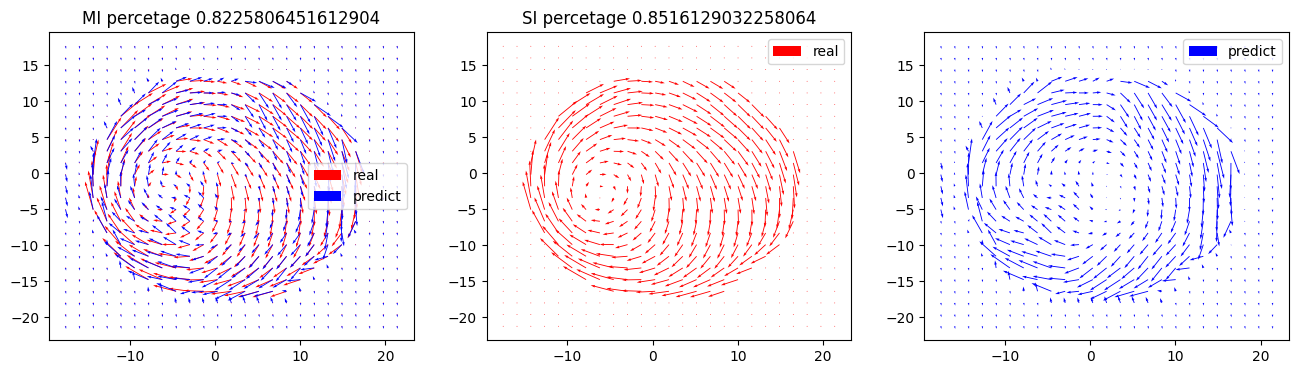

91
MI(average/percent):
0.8579731645314881 0.8193548387096774
SI(average/percent):
0.8981070787549525 0.8516129032258064
92
MI(average/percent):
0.85627590019655 0.8064516129032258
SI(average/percent):
0.898178515095551 0.8548387096774194
93
MI(average/percent):
0.854500406498818 0.8
SI(average/percent):
0.8984997437431779 0.8516129032258064
94
MI(average/percent):
0.8522949145764565 0.7903225806451613
SI(average/percent):
0.8995282839555877 0.864516129032258
95
MI(average/percent):
0.8499998222490616 0.7870967741935484
SI(average/percent):
0.8983974322902002 0.8612903225806452


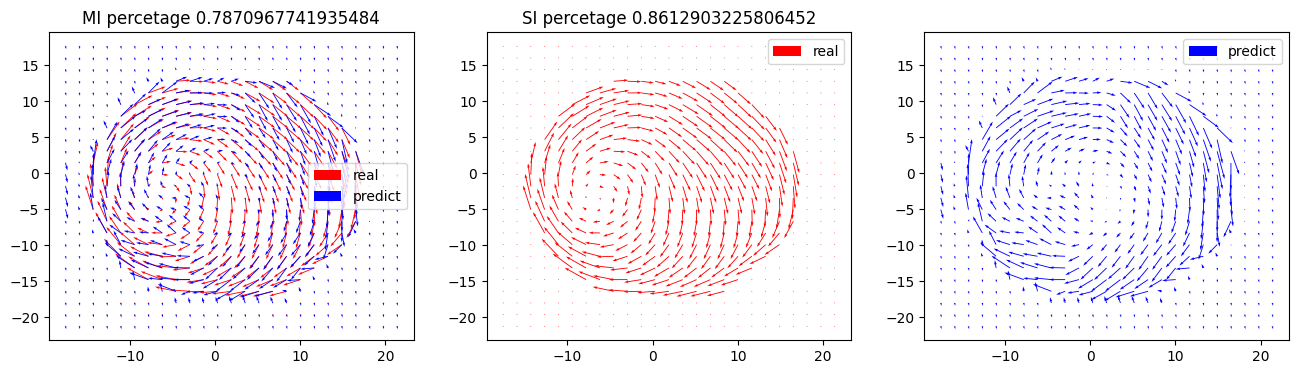

96
MI(average/percent):
0.8476462336491116 0.7806451612903226
SI(average/percent):
0.8960880460058469 0.8548387096774194
97
MI(average/percent):
0.8452856155388584 0.7774193548387097
SI(average/percent):
0.8953004861213256 0.8548387096774194
98
MI(average/percent):
0.8427033507757961 0.7741935483870968
SI(average/percent):
0.8943139619197424 0.8516129032258064
99
MI(average/percent):
0.840139050160182 0.7677419354838709
SI(average/percent):
0.892928840417397 0.8483870967741935
100
MI(average/percent):
0.8376925114550681 0.7677419354838709
SI(average/percent):
0.8908387684712926 0.8483870967741935


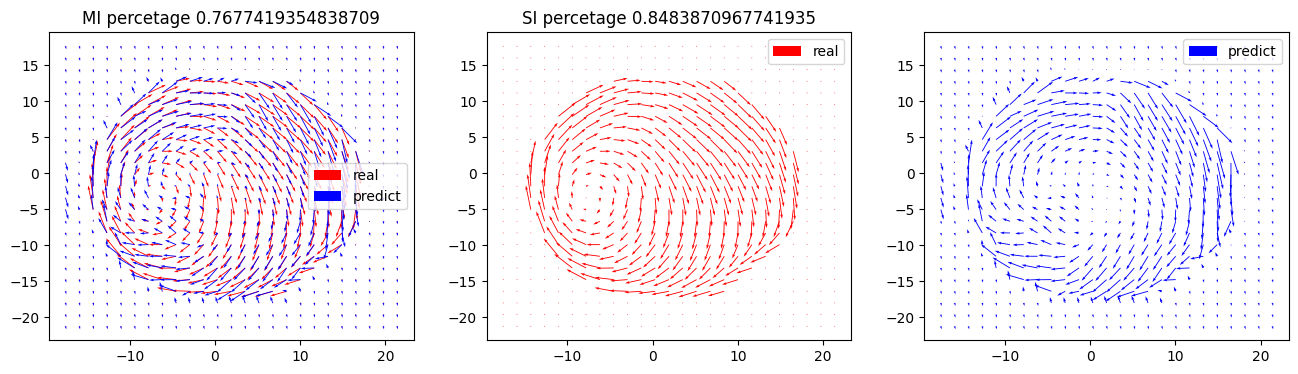

101
MI(average/percent):
0.8374108260498868 0.7612903225806451
SI(average/percent):
0.8900140693691392 0.8516129032258064
102
MI(average/percent):
0.8371736097531074 0.7580645161290323
SI(average/percent):
0.888855204081886 0.8354838709677419
103
MI(average/percent):
0.836843419144137 0.7548387096774194
SI(average/percent):
0.8875340431834834 0.8419354838709677
104
MI(average/percent):
0.8361992922450382 0.7451612903225806
SI(average/percent):
0.886118161900828 0.8354838709677419
105
MI(average/percent):
0.8353107932086373 0.7451612903225806
SI(average/percent):
0.8847022653948067 0.8290322580645161


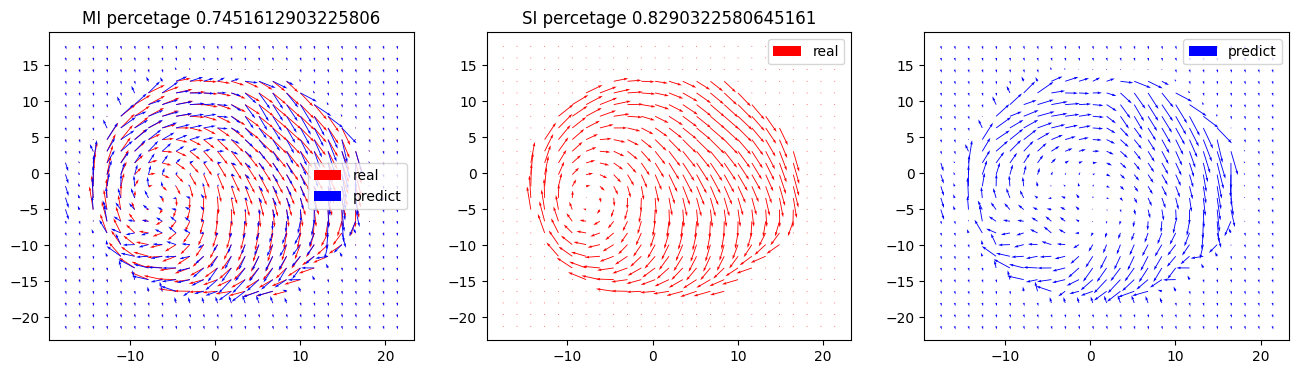

106
MI(average/percent):
0.835833413953941 0.7548387096774194
SI(average/percent):
0.8831449138558336 0.8290322580645161
107
MI(average/percent):
0.8362593743763816 0.7548387096774194
SI(average/percent):
0.8830627965141092 0.832258064516129
108
MI(average/percent):
0.8366754304842416 0.7516129032258064
SI(average/percent):
0.8821788775289117 0.8161290322580645
109
MI(average/percent):
0.8367069631116926 0.7483870967741936
SI(average/percent):
0.8799431198704054 0.8129032258064516
110
MI(average/percent):
0.8366141176754144 0.7419354838709677
SI(average/percent):
0.8765528787144332 0.8064516129032258


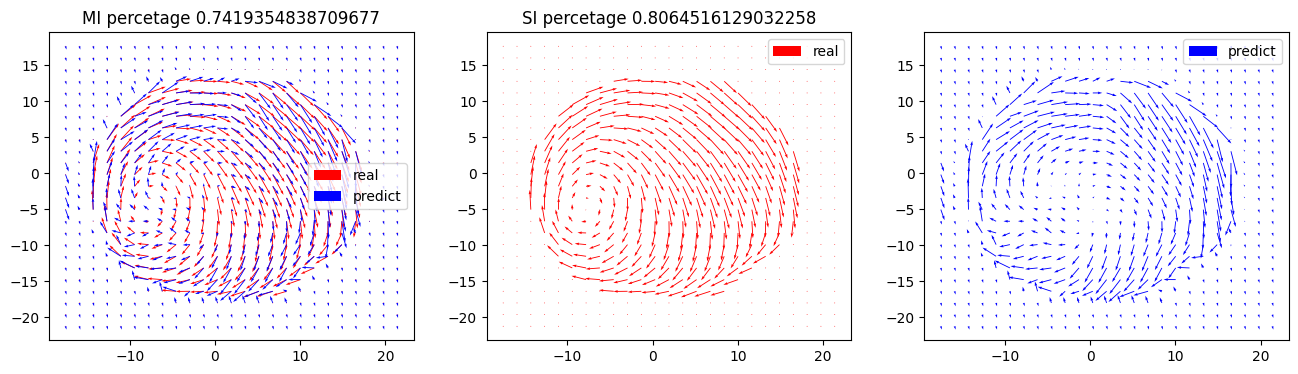

111
MI(average/percent):
0.8363141501738718 0.7451612903225806
SI(average/percent):
0.8749921646322221 0.8096774193548387
112
MI(average/percent):
0.8357491155743146 0.7419354838709677
SI(average/percent):
0.8739314384757338 0.8096774193548387
113
MI(average/percent):
0.8351667624999304 0.7451612903225806
SI(average/percent):
0.8730135263523704 0.8129032258064516
114
MI(average/percent):
0.8345831244026868 0.7451612903225806
SI(average/percent):
0.8723351778189476 0.8096774193548387
115
MI(average/percent):
0.8337749630706498 0.7516129032258064
SI(average/percent):
0.8720178748067284 0.8096774193548387


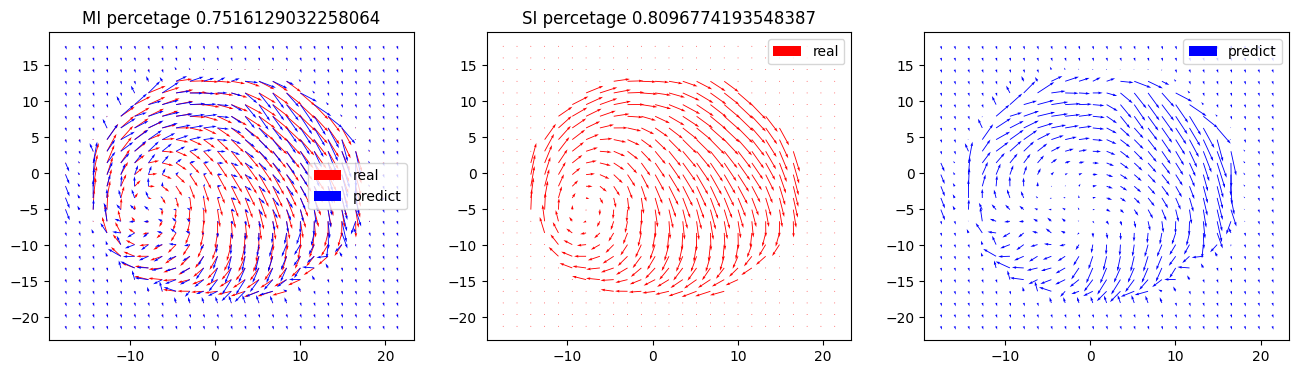

116
MI(average/percent):
0.8350613578648675 0.7483870967741936
SI(average/percent):
0.8735486369510923 0.8064516129032258
117
MI(average/percent):
0.836221943807945 0.7451612903225806
SI(average/percent):
0.8744071358885168 0.8064516129032258
118
MI(average/percent):
0.8373256950274296 0.7516129032258064
SI(average/percent):
0.8748102120329606 0.8
119
MI(average/percent):
0.8378179769877525 0.7516129032258064
SI(average/percent):
0.8752239839405779 0.8064516129032258
120
MI(average/percent):
0.8376407970696195 0.7516129032258064
SI(average/percent):
0.8757148724458366 0.8


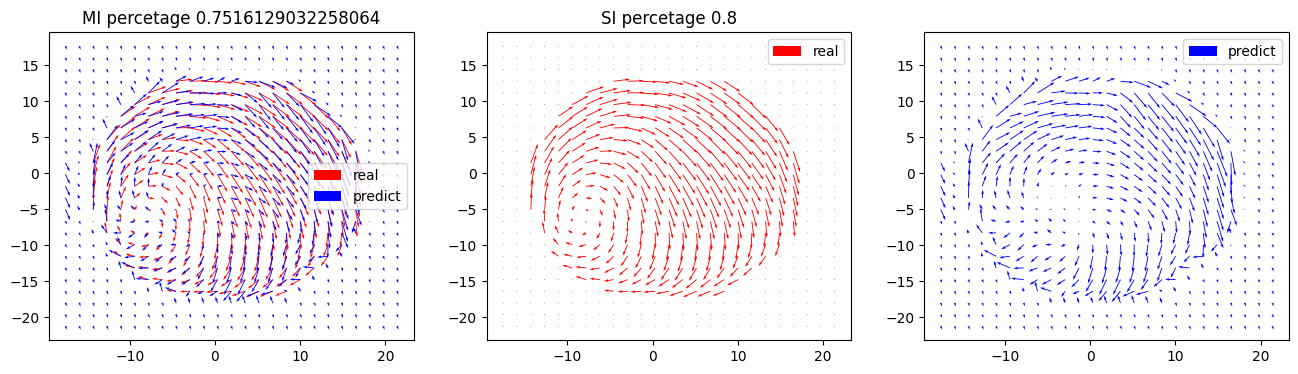

121
MI(average/percent):
0.838070074710518 0.7516129032258064
SI(average/percent):
0.8740496796492703 0.8
122
MI(average/percent):
0.838507172721012 0.7548387096774194
SI(average/percent):
0.8724285721154339 0.8096774193548387
123
MI(average/percent):
0.8389092687394195 0.7419354838709677
SI(average/percent):
0.8727653535410478 0.8032258064516129
124
MI(average/percent):
0.8392989514158118 0.7354838709677419
SI(average/percent):
0.8738945219094754 0.8032258064516129
125
MI(average/percent):
0.83954524837518 0.7354838709677419
SI(average/percent):
0.874993590750278 0.8032258064516129


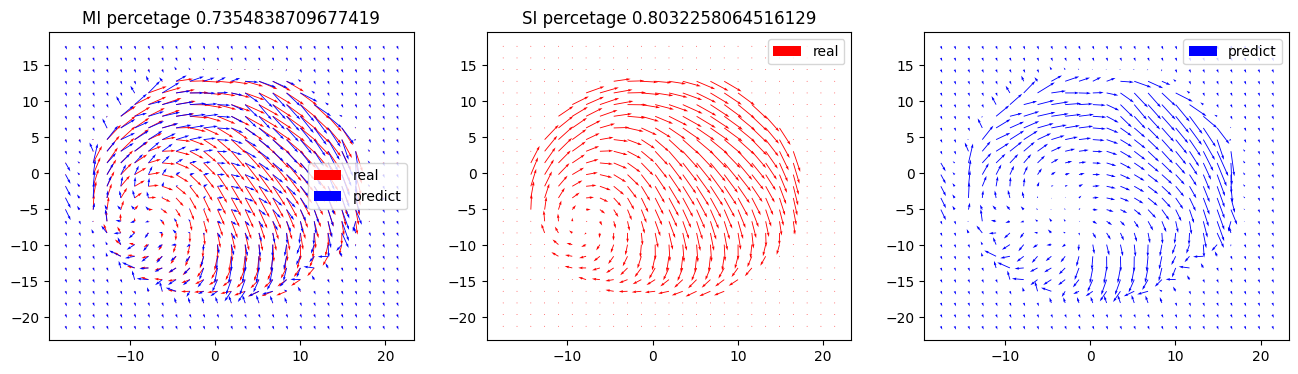

126
MI(average/percent):
0.8392296342773498 0.7419354838709677
SI(average/percent):
0.8771324084129768 0.8032258064516129
127
MI(average/percent):
0.8385155678065854 0.7322580645161291
SI(average/percent):
0.8789703936993398 0.8064516129032258
128
MI(average/percent):
0.8374078810002544 0.7193548387096774
SI(average/percent):
0.8805613166301569 0.8129032258064516
129
MI(average/percent):
0.8362406251192375 0.7096774193548387
SI(average/percent):
0.8814936633414003 0.8161290322580645
130
MI(average/percent):
0.8344957565710174 0.7
SI(average/percent):
0.8819148226497023 0.8193548387096774


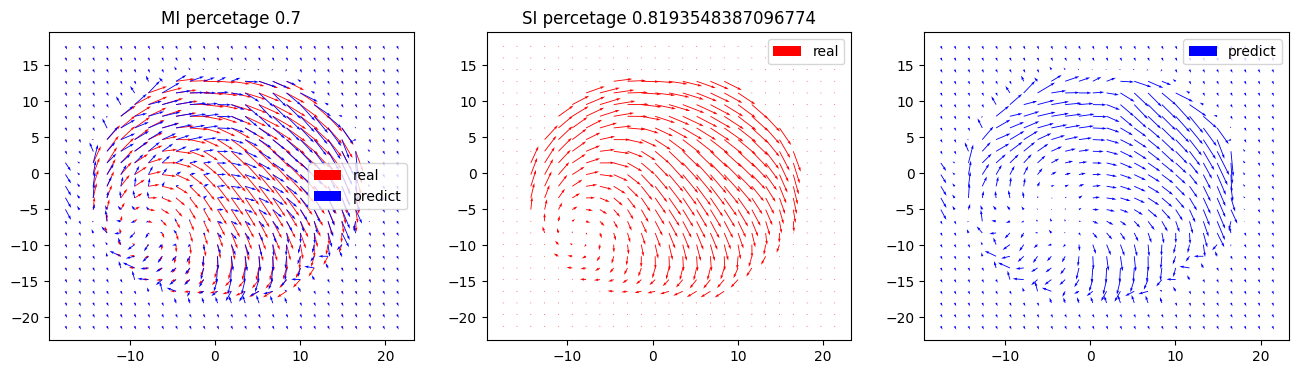

131
MI(average/percent):
0.8350533274539852 0.6935483870967742
SI(average/percent):
0.882643832345714 0.8161290322580645
132
MI(average/percent):
0.8355649056238997 0.6870967741935484
SI(average/percent):
0.8829431782197878 0.8129032258064516
133
MI(average/percent):
0.8360766899786353 0.6967741935483871
SI(average/percent):
0.8834449456739902 0.8129032258064516
134
MI(average/percent):
0.8367439733604762 0.6967741935483871
SI(average/percent):
0.8835786999940203 0.8225806451612904
135
MI(average/percent):
0.8376198954073164 0.6967741935483871
SI(average/percent):
0.8830897055901352 0.8225806451612904


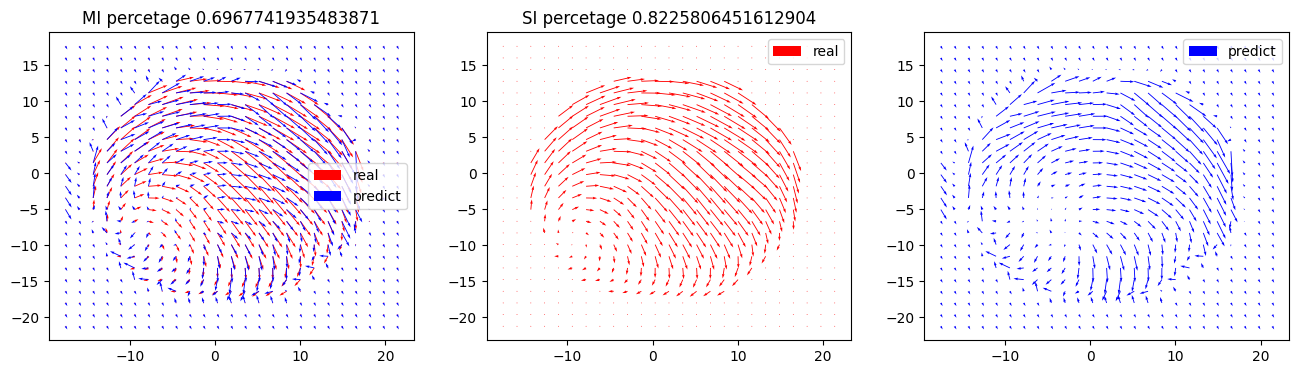

136
MI(average/percent):
0.8370737970224009 0.7096774193548387
SI(average/percent):
0.8825463168772959 0.8129032258064516
137
MI(average/percent):
0.8362094279948732 0.7129032258064516
SI(average/percent):
0.8818482265136188 0.8096774193548387
138
MI(average/percent):
0.8354073982295227 0.7161290322580646
SI(average/percent):
0.8794845846421468 0.8064516129032258
139
MI(average/percent):
0.8347028980868479 0.7193548387096774
SI(average/percent):
0.8764677428032469 0.8096774193548387
140
MI(average/percent):
0.8340136543873484 0.7161290322580646
SI(average/percent):
0.8757639043629197 0.8064516129032258


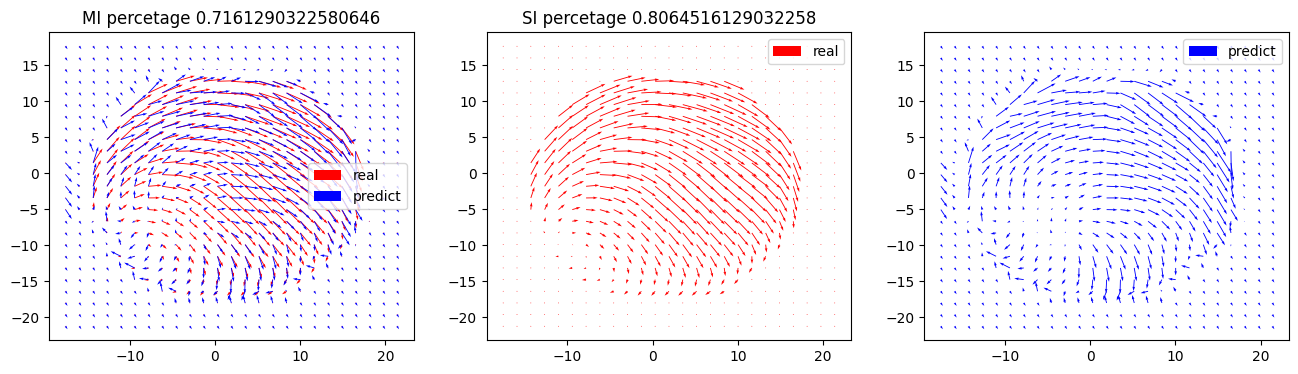

141
MI(average/percent):
0.8338423337504488 0.7193548387096774
SI(average/percent):
0.8732655431455522 0.7935483870967742
142
MI(average/percent):
0.833895267115227 0.7064516129032258
SI(average/percent):
0.8692872192464034 0.7967741935483871
143
MI(average/percent):
0.8342587754535581 0.7129032258064516
SI(average/percent):
0.8639843726749735 0.7935483870967742
144
MI(average/percent):
0.8349649844933299 0.7193548387096774
SI(average/percent):
0.8593260525936428 0.7935483870967742
145
MI(average/percent):
0.8360679325097246 0.7322580645161291
SI(average/percent):
0.854202375973726 0.7935483870967742


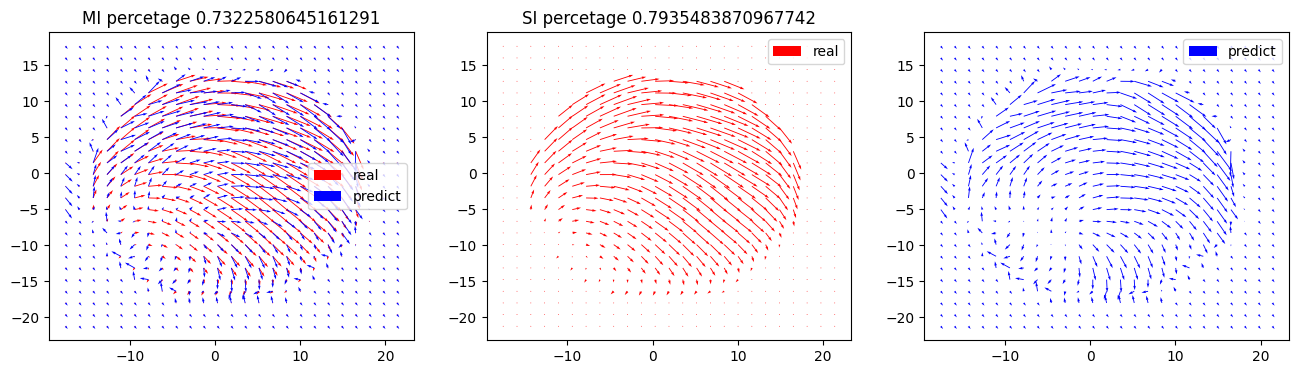

In [18]:
for i in range(p_tot):
    print(i)
    j=i
    mi_t[i],mi_t_per[i]=miscore(pltpredict[:,:,j,],v_test[:,:,j,:])
    si_t[i],si_t_per[i]=siscore(pltpredict[:,:,j,],v_test[:,:,j,:])
    if i%(addp)==0:
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 3, 1)
        plt.title('MI percetage '+str(mi_t_per[i]))
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
        plt.legend()
        plt.subplot(1, 3, 2)
        plt.title('SI percetage '+str(si_t_per[i]))
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
        #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
        plt.legend()
        plt.subplot(1, 3, 3)
        #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
        plt.legend()
        plt.show()
    

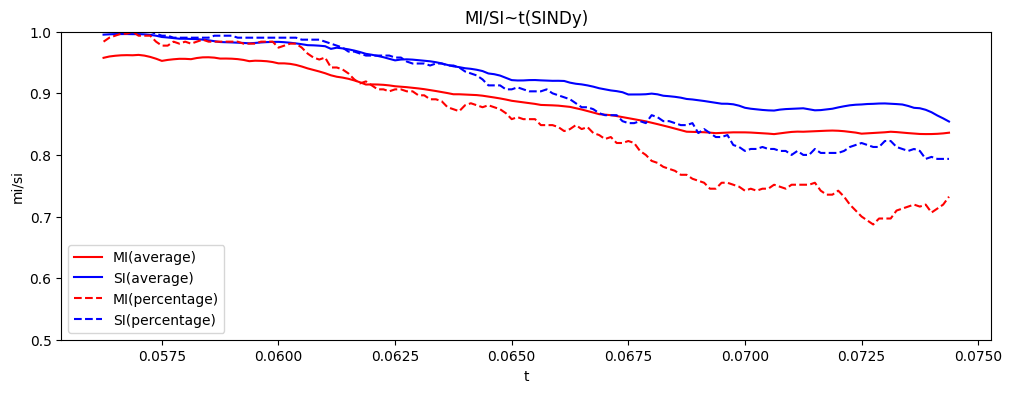

In [14]:
plt.figure(figsize=(12, 4))
plt.title('MI/SI~t(SINDy)')
plt.ylim(0,1)
plt.xlabel('t')
plt.ylabel('mi/si')
plt.plot(t_train,mi_t,'r',label='MI(average)')
plt.plot(t_train,si_t,'b',label='SI(average)')
plt.plot(t_train,mi_t_per,'r--',label='MI(percentage)')
plt.plot(t_train,si_t_per,'b--',label='SI(percentage)')
plt.legend()
plt.ylim(0.5, 1)
plt.plot
plt.show()